### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, restoration, filters

# Modules
from RICM_VESICLE import RICM

# Functions
def avg_movie(movie, l=2, keep_dim =True, show_dim=True):
    
    # Average each l frames
    movie_avg = []
    if keep_dim:
        for i in range(int(movie.shape[0]-movie.shape[0]%l-l)):
            movie_avg.append(np.mean(movie[i:i+l], axis=0))
    else:
        for i in np.arange(int(movie.shape[0]-movie.shape[0]%l), step=l):
            movie_avg.append(np.mean(movie[i:i+l], axis=0))
    
    # Transform the movie into numpy array
    movie_avg = np.array(movie_avg)
    
    # Show the dimension reduction
    if show_dim == True:
        print("{} --> {}".format(movie.shape, movie_avg.shape))
    
    return movie_avg

### Determine the Movie

In [2]:
# Determine the Experiment and the GUV number
EXPERIMENT = '20220125_GUV2_on_SOPC2'
DATA = 'Experiment-16738'
GUV = 1

### Read the RICM image for one GUV

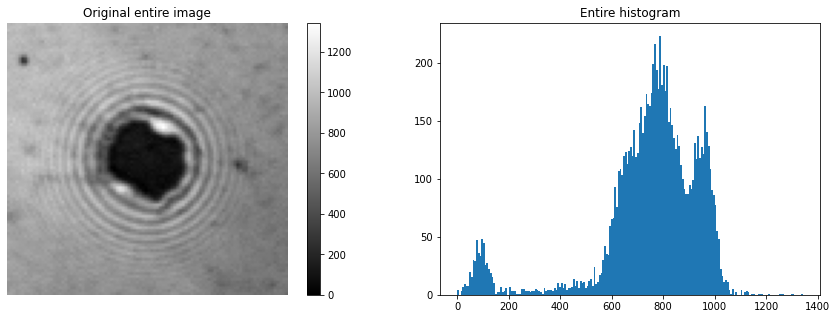

In [3]:
# Read the image
guv = io.imread(f"Data/{EXPERIMENT}/data/{DATA}-{GUV}.tif")[:]

# Subtract the base line
guv = guv - guv[400:450].mean(axis = 0).min()

# Take the average
guv_avg = guv[400:450].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

### Define the RICM model to get the bacground corrected image

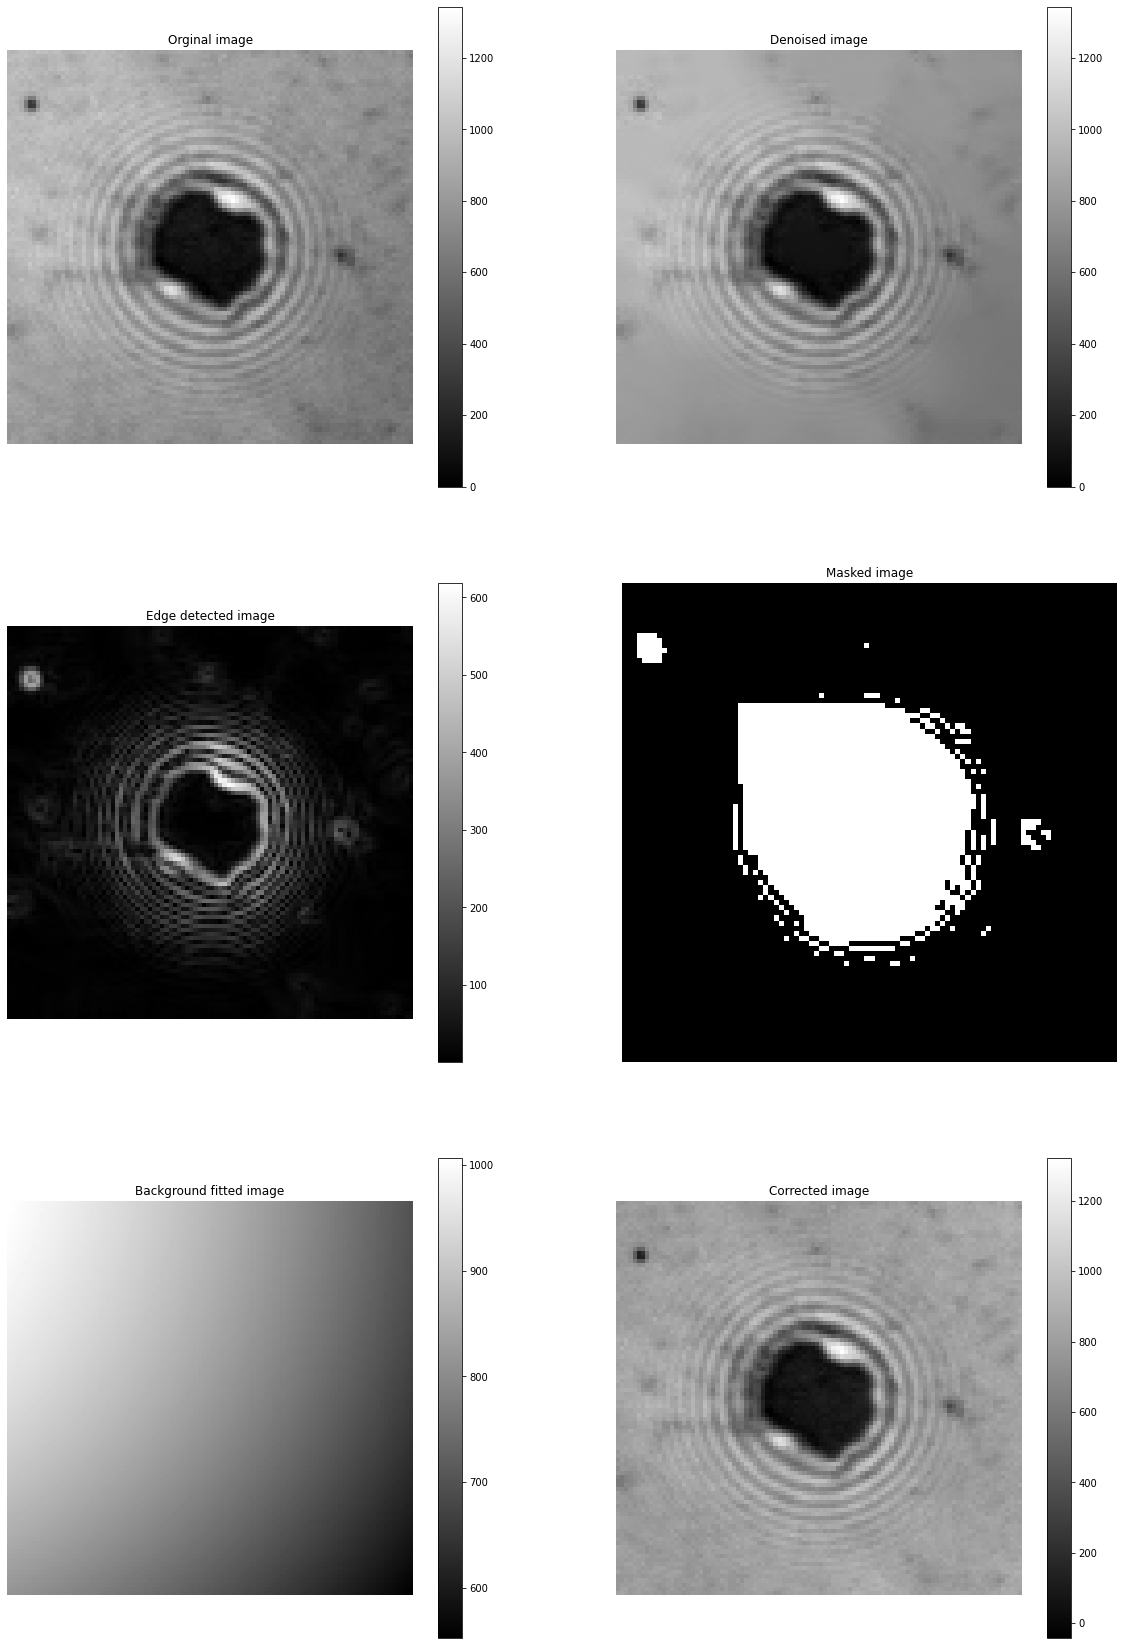

In [4]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

### The histogram of the corrected GUV

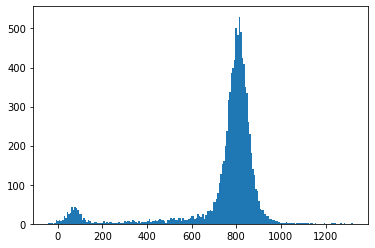

In [5]:
plt.hist(ricm.correct().ravel(), bins = 200);

In [6]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=5, keep_dim=False)

(930, 95, 98) --> (186, 95, 98)


### Measure the area of each frame
#### With background correction

In [7]:
%%time

# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# Define the background
background = ricm.background_fitting()
background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1]))

# Get the area of each frame in the averaged movie
area = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm on the background corrected image
    img_corrected = restoration.denoise_nl_means(guv_consecutive[i] + background_correction,
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20)

    # Compute the area
    area.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area = np.array(area)

CPU times: user 24.4 s, sys: 61.4 ms, total: 24.5 s
Wall time: 24.4 s


(159,) (159,)


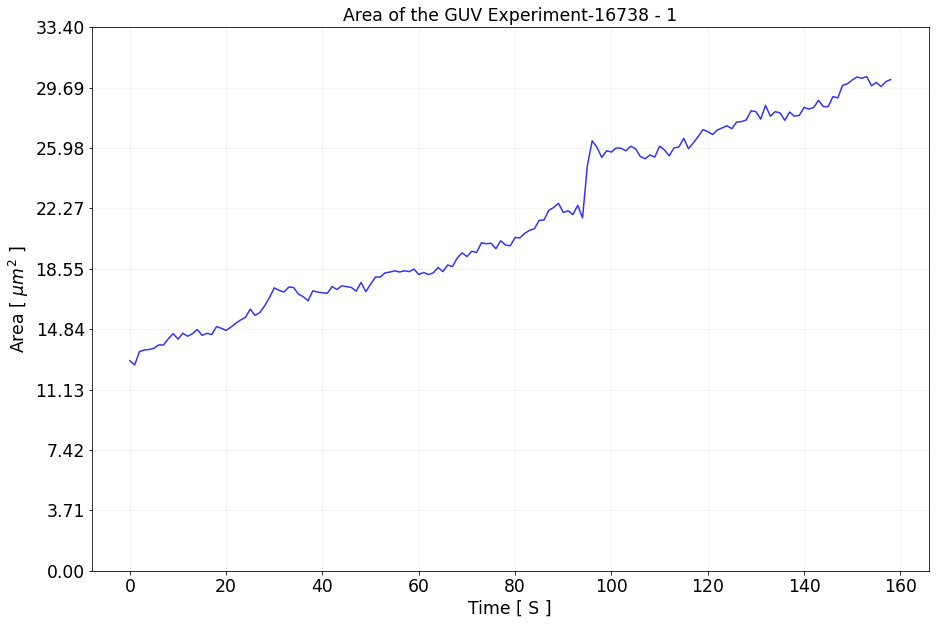

In [8]:
# Define the curve and the time interval
area_curve = area[27:] * 0.16**2
time = np.arange(0, area_curve.shape[0]*1, 1)

print(area_curve.shape, time.shape)

# Define data frame for the scaled time and area
df = pd.DataFrame(data={'Time':time, 'Area':area_curve})

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(df['Time'], df['Area'], label = f'{DATA}_{GUV}', color = 'b', alpha = 0.8)

plt.title(f'Area of the GUV {DATA} - {GUV}', fontsize= 'xx-large')
plt.xlabel('Time [ S ]', fontsize = "xx-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "xx-large")
plt.xticks(fontsize = "xx-large")
plt.yticks(np.linspace(0,area_curve.max() + area_curve.max()/10,10),fontsize = "xx-large")
plt.grid(color = 'gray', alpha = 0.1)

# Save the figure into png
plt.savefig(f"Data/{EXPERIMENT}/results/{DATA}-{GUV}")

# Save the data into csv
df.to_csv(f"Data/{EXPERIMENT}/results/{DATA}-{GUV}.csv", index=False)